In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Luca\Anaconda3\envs\bio\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# PyGMQL in action

## Problem description
We are given three replicas of a ChIP-Seq experiment.
We want to:
1. Extract **high-confidence regions** into one sample
2. Identify which of these regions **overlap** with a set of given genes
3. For each resulting region count ICGC **mutations**.
4. Finally we want to select the regions with **at least one** mutation.

## Required GMQL operations
For this pipeline we will need the following GMQL operations:
- ```cover```: extracts regions which are confirmed by at least two replicas
- ```join```: extracts regions which overalap with genes
- ```map```: for each extracted region, counts the overlapping mutations

## PyGMQL in a nutshell

PyGMQL enables the writing of GMQL queries using the Python programming language. It exposes to the user all the GMQL operators and also a data structure for holding, manipulating and converting the results of a GMQL query.

The library offers:
- A data structure called ```GMQLDataset```, which represent a GMQL variable in the query. Every GMQLDataset is produced by a GMQL operator. When you call the ```materialize``` operation on a GMQLDataset the execution is started and the result is returned.
- A data structure called ```GDataframe```, holding the result of a query. A GDataframe is a pure python structure and can be used directly as any other pandas dataframe. A GDataframe holds two pandas dataframes, one for the regions and one for the metadata. We can also, given a GDataframe, go back to a GMQLDataset for using it as a GMQL variable. This can be done calling the ```to_GMQLDataset``` function of the GDataframe.

<img src="./images/GMQLDataset_to_GDataframe.png" width="500" height="600">

### Getting the library

The library can be downloaded from the PyPi public repository through the ```pip``` packaging system.

```
    pip install gmql
```

If you want the most recent version of the software you can directly download it from the GitHub page:

```
    git pull https://github.com/DEIB-GECO/PyGMQL.git
    cd PyGMQL
    pip install -e .
```

### Importing the library

In [2]:
import gmql as gl
import pandas as pd

### Execution modes
The queries are directly embedded inside the language and can be executed in two different modes:
- *Local mode*: the computation is executed in the local machine
- *Remote mode*: the query is sent to a remote server, executed there and the results are downloaded. This process is shown in the figure below.

<img src="./images/remote.png">

In [3]:
gl.set_mode("local")
gl.set_progress(False)

## The query

The GMQL query that we are going to present is the following:

```
refSeqGenes  = SELECT(annotation_type == 'gene' AND provider == 'RefSeq') HG19_BED_ANNOTATION;

myExp  = SELECT() myRawExp;
myConfirmExp  = COVER(2, ANY) myExp;

myExpOverGenes  = JOIN(DIST < 0; output: RIGHT_DISTINCT) refSeqGenes myConfirmExp;

myMut  = SELECT() myRawMut;
myMutOverExp = MAP() myExpOverGenes myMut;

myFilteredExp = SELECT(region: count_myMutOverExp_myMut > 0) myMutOverExp;

MATERIALIZE myFilteredExp INTO ./Results/FilteredExperiment
    
```

## Loading a GMQL dataset

### Loading datasets in GDM format

Both the gene dataset and the personal one are already in the GDM format, therefore the library only needs the location of the data for importing.

*NB: This demo is meant to be executed without the need of a remote server. For this reason the HG19_BED_ANNOTATION dataset is loaded directly from the computer disk. Please be aware that it can also be found in the regular GMQL repository.*

In [4]:
bed_annotation = gl.load_from_path("./Data/HG19_BED_ANNOTATION/")

In [5]:
myExp = gl.load_from_path("./Data/myRawExp/")

### Loading datasets with a generic schema

The mutation dataset is in a classical BED format but not in the GDM format, therefore we need to specify its schema through a **custom parser**, which is an instance of a ```RegionParser```. 
After the parser is instantiated we can use the ```load_from_path``` function to load the dataset, which is currently stored in the local file system

In [6]:
mutations_parser = gl.parsers.RegionParser(parser_name="mutations_parser",
                                           chrPos=0,
                                           startPos=1,
                                           stopPos=2,
                                           strandPos=3,
                                           delimiter="\t")

In [7]:
myMut = gl.load_from_path("./Data/myRawMut/", parser=mutations_parser)

## Selection on the metadata

We have in the variable ```bed_annotation``` all the ENCODE dataset of annotations. We are interested only in the annotations regarding the genes. Therefore we need to *filter* the dataset **on the basis of the metadata**.
This is called ```meta-selection``` and in PyGMQL can be performed using the square-bracket notation common to pandas users.

In [8]:
refSeqGenes = bed_annotation[(bed_annotation['annotation_type'] == 'gene') & 
                             (bed_annotation['provider'] == 'RefSeq')]

## Cover operation
We want only reliable data from the Chip-Seq experiment, therefore we define a Chip-Seq region *highly confident* if it is confirmed by at least two replicas. This is a job for the ```cover``` operation.

- ```minAcc```: we define the minimum number of overlapping between samples for a region to be conserved. In this case 2.
- ```maxAcc```: we define the maximum number. The ```"ANY"``` keyword makes the upper bound infinite.

<img src="./images/cover.PNG">

In [9]:
myConfirmExp = myExp.normal_cover(minAcc=2, maxAcc="ANY")

## Join
Now we want to extract those regions that overlap with genes. We can do it using the ```join``` operation. 
- We use the genes as reference dataset
- The Chip-Seq regions as experiment. 
- The genometric predicate ```DLE(0)``` and the option ```output="RIGHT"``` tell the engine to look at all the experiment regions that happen to intersect with the reference ones and keep them in the result.

<img src="./images/join.PNG" height="700" width="700">

In [10]:
myExpOverGenes = refSeqGenes.join(experiment=myConfirmExp, refName="gene",
                                  genometric_predicate=[gl.DLE(0)],
                                  output="RIGHT_DISTINCT")

## Map
Now in ```insideGene``` we have the set of highly confident Chip-Seq regions that intersect with a gene. In order to see how many mutations happen in those region we can use the ```map``` operation. This operation will add a new attribute to the resulting dataset which will be named ```count_GENE_MUTATION```.

<img src="./images/map.PNG">

In [11]:
myMutOverExp = myExpOverGenes.map(myMut, expName="MUTATION", refName="GENE")

## Selection on regions
In order to filter out all the regions in ```mutationCount``` that do not have any mutation we can do a selection on region data using the ```reg_select``` operation. This operation takes as input a predicate on region fields.

In [12]:
myFilteredExp = myMutOverExp.reg_select(myMutOverExp.count_GENE_MUTATION > 0)

## Materialization
We can now materialize the result. PyGMQL adopts a *lazy loading* approach (like Spark) and no action is performed until materialization. The result can be saved as a GDM dataset and also directly loaded in python as a ```GDataframe```.

In [13]:
result = myFilteredExp.materialize("./Results/FilteredExperiment/")

## The GDataframe
The result of a materialization is a ```GDataframe``` which contains both regions and metadata as two Pandas dataframes ```regs``` and ```meta```

In [14]:
result.regs.head()

,chr,start,stop,strand,accindex,jaccardintersect,jaccardresult,count_gene_mutation
S_00000.gdm,chr1,8035225,8035786,*,3,0.921182,0.748768,1.0
S_00000.gdm,chr1,11779578,11780328,*,3,0.651607,0.501303,1.0
S_00000.gdm,chr1,11898457,11899199,*,3,0.876033,0.783943,1.0
S_00000.gdm,chr1,17286965,17287470,*,3,0.698479,0.641770,1.0
S_00000.gdm,chr1,22140883,22141897,*,3,0.910233,0.754937,2.0


The region dataframe represents the regions in the output result in a tabular format. The index of the regions is the identifier of the sample they belong to.

In [15]:
result.meta

,GENE.ID,GENE.antibody,GENE.antibody_antibodyDescription,GENE.antibody_lab,GENE.antibody_label,GENE.antibody_lots,GENE.antibody_orderUrl,GENE.antibody_tag,GENE.antibody_target,GENE.antibody_targetClass,...,GENE.treatment_tag,GENE.treatment_type,GENE.type,GENE.url,GENE.view,GENE.view_description,GENE.view_label,GENE.view_tag,GENE.view_type,MUTATION.type
id_sample,,,,,,,,,,,,,,,,,,,,,
S_00000.gdm,"[1880, 1881, 1882]",[CTCF],[Rabbit polyclonal. Antibody Target: CTCF],"[Myers, Hardison, Snyder]",[CTCF (07-729)],[1350637 DAM1472197],[http://www.millipore.com/catalogue/item/07-729],[CTCF],[CTCF],[TFSS],...,[NONE],[control],[broadPeak],[http://hgdownload.cse.ucsc.edu/goldenPath/hg1...,[Hotspots],[ChIP-seq affinity zones identified using the ...,[Hotspots],[HOTSPOTS],[view],[mutations]


The metadata dataframe has as columns all the metadata attributes and every row represents a sample in the output dataset. 

There can be multiple values in the same cell.

## Additional operations
Having the result in a Pandas dataframe enables us to use all the Pandas functions and perform some statistics.

For example we can do an histogram of the mutation counts over the Chip-Seq regions showing the distribution of the number of mutations over those regions.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FF7CDAF668>]], dtype=object)

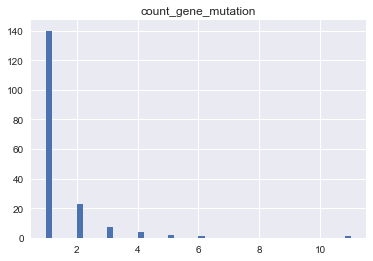

In [16]:
plt.figure(figsize=(25, 20))
result.regs[result.regs.count_gene_mutation <=50].hist("count_gene_mutation", bins=50)

Of course we can also simply display the mean value

In [17]:
result.regs['count_gene_mutation'].mean()

1.404494382022472

### High density regions

In [18]:
result.regs[result.regs.count_gene_mutation > 5].sort_values("count_gene_mutation", ascending=False)

,chr,start,stop,strand,accindex,jaccardintersect,jaccardresult,count_gene_mutation
S_00000.gdm,chr19,19296510,19297234,*,3,0.860880,0.764566,11.0
S_00000.gdm,chr19,49495965,49497004,*,3,0.913808,0.000000,6.0


## Alternative experiment
Mapping the mutations over the genes instead that over the experiment regions


The GMQL query that we are going to present is the following:

```
refSeqGenes  = SELECT(annotation_type == 'gene' AND provider == 'RefSeq') HG19_BED_ANNOTATION;

myExp  = SELECT() myRawExp;
myConfirmExp  = COVER(2, ANY) myExp;

myExpOverGenes  = JOIN(DIST < 0; output: RIGHT_DISTINCT) refSeqGenes myConfirmExp;

myMut  = SELECT() myRawMut;
myMutOverExp = MAP() myExpOverGenes myMut;

myFilteredExp = SELECT(region: count_myMutOverExp_myMut > 0) myMutOverExp;

MATERIALIZE myFilteredExp INTO ./Results/FilteredExperiment
    
```

In [19]:
genesOverExp = refSeqGenes.join(experiment=myConfirmExp, refName="gene",
                                  genometric_predicate=[gl.DLE(0)],
                                  output="LEFT_DISTINCT")
myMutOverGenes = genesOverExp.map(myMut, expName="MUTATION", refName="GENE")
myFilteredGenes = myMutOverGenes.reg_select(myMutOverGenes.count_GENE_MUTATION > 0)
result_genes = myFilteredGenes.materialize("./Results/FilteredGenes/")

In [20]:
result_genes.regs.head()

,chr,start,stop,strand,name,score,count_gene_mutation
S_00000.gdm,chr1,1716723,1822556,-,NM_002074,0.0,2.0
S_00000.gdm,chr1,1716723,1822556,-,NM_001282539,0.0,2.0
S_00000.gdm,chr1,1716723,1822556,-,NM_001282538,0.0,2.0
S_00000.gdm,chr1,2115898,2139172,-,NM_001146310,0.0,2.0
S_00000.gdm,chr1,2120987,2144159,-,NM_001282670,0.0,2.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FF7D1614A8>]], dtype=object)

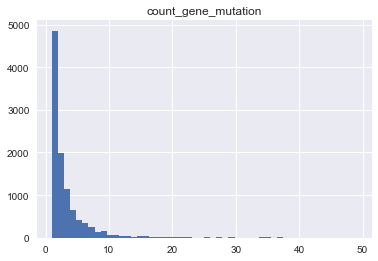

In [21]:
plt.figure(figsize=(25, 20))
result_genes.regs[result_genes.regs.count_gene_mutation <=50].hist("count_gene_mutation", bins=50)

In [22]:
result_genes.regs['count_gene_mutation'].mean()

3.4381662107348365

In [23]:
result_genes.regs[result_genes.regs.count_gene_mutation > 50].sort_values("count_gene_mutation", ascending=False)

,chr,start,stop,strand,name,score,count_gene_mutation
S_00000.gdm,chr4,144498560,144621828,-,NM_001168235,0.0,283.0
S_00000.gdm,chr15,78463186,78527049,-,NM_001199377,0.0,141.0
S_00000.gdm,chr15,78463186,78527049,-,NM_015162,0.0,141.0
S_00000.gdm,chr2,27505296,27530307,+,NM_032546,0.0,114.0
S_00000.gdm,chr2,27505296,27530307,+,NM_187841,0.0,114.0
S_00000.gdm,chr11,116714117,116969131,-,NM_025164,0.0,99.0
S_00000.gdm,chr11,116714117,116969131,-,NM_001281749,0.0,99.0
S_00000.gdm,chr11,116714117,116969131,-,NM_001281748,0.0,99.0
S_00000.gdm,chr4,144257982,144395718,+,NM_002039,0.0,87.0
S_00000.gdm,chr4,144257982,144395718,+,NM_207123,0.0,87.0
